# Coherence Analyses

This notebook contains codes that were used to make the images represented in my CWP report for the spring of 2024. Generally, it makes a comparison of qr vs traditional computation of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

### Make imports and write functions

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import ifft

# from sklearn.utils.extmath import randomized_svd
import time

# sys.path.append('../')
sys.path.append(os.path.join(os.path.dirname(""), os.pardir, os.pardir))
import coherence_analysis.utils as f

### Parameters for data and tests

In [2]:
samples_per_sec = 1000
fsize = 15
tick_size = 12
nsensors = 200
# start_ch = 1000
# nchannels = 3000

start_ch = 3100
nchannels = 2000
# nchannels = 5100

# start_ch = 10
# nchannels = 3000

# start_ch = 5500
# nchannels = 2500

# start_ch = 100
# nchannels = 5000

# start_ch = 4600
# nchannels = 1000

win_len = 2.5
overlap = 0

subwin_width = 4096  # number of samples in each subwindow
num_subwins = 10  # number of subwindows to average over
avgwin_width = (
    num_subwins * subwin_width
)  # number of samples in averaging window

colors = ["#800000", "#FFD700", "#663399", "#000000", "#008B8B"]

# Background noise test

In [3]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data_noise = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000118.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data_noise = np.append(data_noise, data2[:, :10000], axis=1)

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314174012.h5"
# data, _ = f.load_brady_hdf5(file, normalize="no")

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314174042.h5"
# data2, _ = f.load_brady_hdf5(file, normalize="no")

In [4]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
)
welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
coherence = np.absolute(welch_coherence_mat) ** 2

# coherence, frequencies = welch_coherence(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

Calculate the detection parameter,

$$\frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

at each frequency. Here $\lambda_i$ is the $i^{th}$ eigenvalue of the coherence matrix.

In [5]:
num_frames = coherence.shape[0]

eig_ratios = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_svd = np.empty(num_frames)

for d in range(num_frames):
    eigenvals = np.linalg.eigvalsh(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0] / np.sum(eigenvals)

    Q, R = np.linalg.qr(norm_win_spectra[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R @ R.transpose())) ** 2)[::-1]
    qr_approx2 = np.sort(np.diag(R @ np.conjugate(R.transpose())))[::-1]
    eig_ratios_qr[d] = qr_approx2[0] / np.sum(np.absolute(qr_approx2))

    S = np.linalg.svd(norm_win_spectra[d], compute_uv=False, hermitian=False)
    svd_approx2 = np.sort(S)[::-1] ** 2
    eig_ratios_svd[d] = svd_approx2[0] / np.sum(np.absolute(svd_approx2))

C:\Users\issah\AppData\Local\Temp\ipykernel_39836\100692073.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios_qr[d] = qr_approx2[0] / np.sum(np.absolute(qr_approx2))


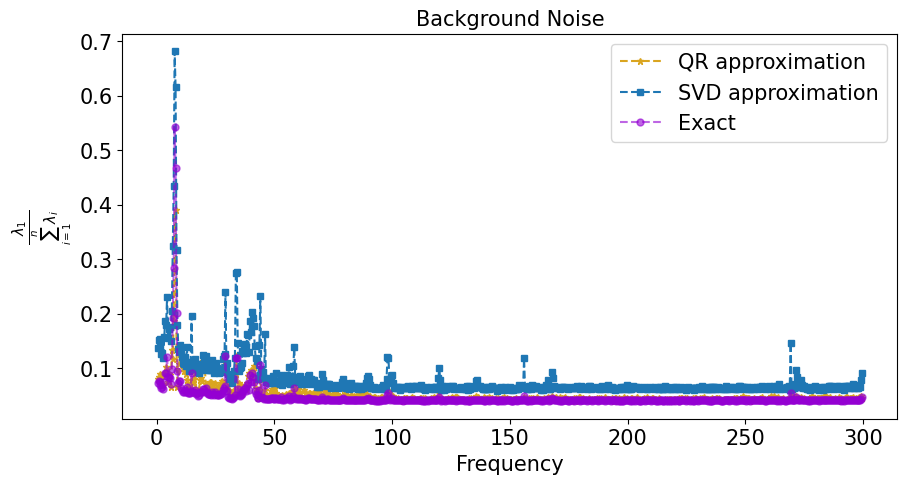

In [6]:
last_freq_index = 750

plt.figure(figsize=(10, 5))

plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_qr[1:last_freq_index],
    "--*",
    markersize=5,
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_svd[1:last_freq_index],
    "--s",
    markersize=5,
    label="SVD approximation",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios[1:last_freq_index],
    "--o",
    markersize=5,
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)

plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.title("Background Noise", fontsize=fsize)
plt.legend(fontsize=fsize)

### Plot data

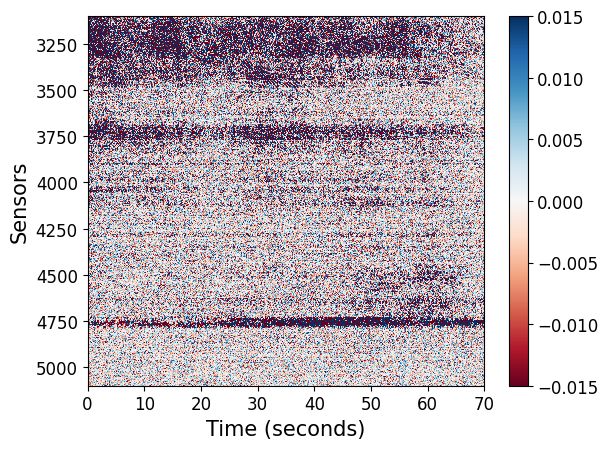

In [7]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1)
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
tick_size = 12
ch_start = 1
# v_min = -np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
# v_max = np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
v_min = -0.015
v_max = 0.015

# pdata = data[3000:8000, 47240:53256]

fig2 = plt.figure()
img2 = plt.imshow(
    data_noise[start_ch : nchannels + start_ch],
    cmap="RdBu",
    # img2 = plt.imshow(data_noise[3000:8000, 47240:53256], cmap="RdBu",
    vmin=v_min,
    vmax=v_max,
    aspect="auto",
    interpolation="none",
    extent=(0, 70, nchannels + start_ch, start_ch),
)
#    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
# plt.ylabel("Channels", fontsize=fsize)
plt.ylabel("Sensors", fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Event test

In [8]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

# data = np.append(data, data2, axis=1)

data = np.append(data, data2[:, :10000], axis=1)

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083948.h5"
# data2,_= f.load_brady_hdf5(file,normalize='no')

# data = np.append(data, data2[:, :10000], axis=1)

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
# data = np.append(data, data2, axis=1)
# data = np.append(data,data3[:,:20000],axis=1)
samples_per_sec = 1000

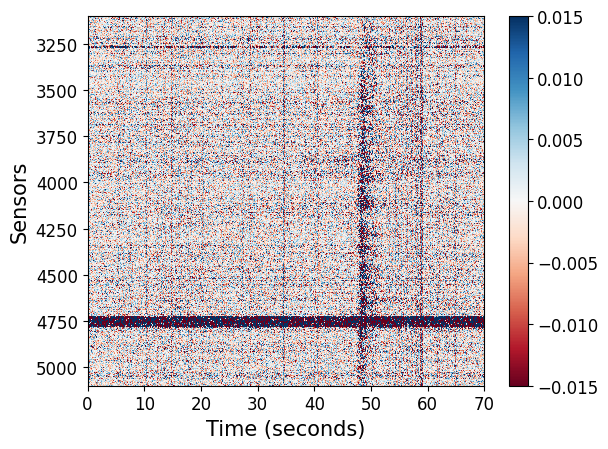

In [9]:
# v_min = -np.percentile(np.absolute(data[start_ch:nchannels+start_ch]),95)
# v_max = np.percentile(np.absolute(data[start_ch:nchannels+start_ch]),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure()
img2 = plt.imshow(
    data[start_ch : nchannels + start_ch],
    cmap="RdBu",
    # img2 = plt.imshow(data[3000:8000], cmap="RdBu",
    vmin=v_min,
    vmax=v_max,
    aspect="auto",
    interpolation="none",
    extent=(0, 70, nchannels + start_ch, start_ch),
)
#    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
plt.ylabel("Sensors", fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

In [10]:
t0 = time.time()
norm_win_spectra2, frequencies = f.normalised_windowed_spectra(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
)
t1 = time.time()
common_time = t1 - t0
welch_coherence_mat = np.matmul(
    norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0, 2, 1))
)
coherence2 = np.absolute(welch_coherence_mat) ** 2

# coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

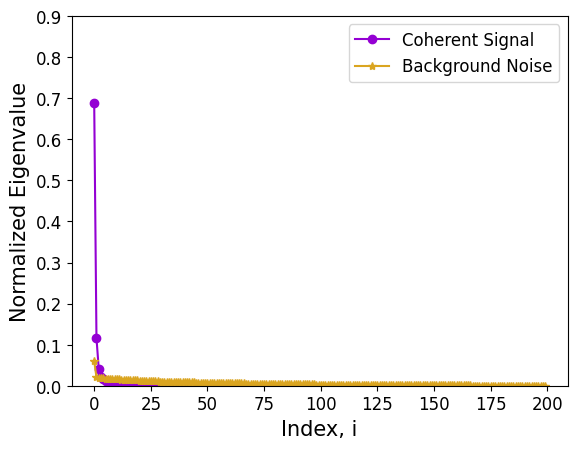

In [11]:
i = 35
tick_size = 12
# eigenvals, eigenvecs = np.linalg.eig(coherence[i])
eigenvals2, eigenvecs = np.linalg.eig(coherence2[i])
S = np.linalg.svd(norm_win_spectra2[i], compute_uv=False, hermitian=False)
svd_approx2 = np.sort(S)[::-1] ** 2
# eig_ratios_svd2[d] = svd_approx2[0] / np.sum(np.absolute(svd_approx2))
# plt.imshow(coherence[0])
# plt.colorbar()
plt.plot(
    np.sort(svd_approx2 / np.sum(svd_approx2))[::-1],
    # np.sort(eigenvals2 / np.sum(eigenvals2))[::-1],
    "-o",
    color="darkviolet",
    label="Coherent Signal",
)
plt.plot(
    np.sort(eigenvals / np.sum(eigenvals))[::-1],
    "-*",
    color="goldenrod",
    label="Background Noise",
)

# plt.plot(
#     np.sort(eigenvals2 / np.sum(eigenvals2))[::-1],
#     "-o",
#     color=colors[0],
#     label="Coherent Signal",
# )
# plt.plot(
#     np.sort(eigenvals / np.sum(eigenvals))[::-1],
#     "-*",
#     color=colors[1],
#     linewidth=2,
#     label="Noise",
# )

# plt.yscale('log')
# plt.ylabel("Detection parameter",fontsize=fsize)
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
# plt.ylabel(
#     r"$\frac{\lambda_i}{\sum_{k=1}^{n} \lambda_k}$",
#     fontsize=fsize + 2,
#     rotation="horizontal",
#     labelpad=20,
# )
# plt.ylabel('$\lambda_1/\sum \lambda_n$', fontsize=fsize)
plt.xlabel("Index, i", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim([0, 0.9])
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals2[0]/np.sum(eigenvals2))), color = "darkviolet", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals[0]/np.sum(eigenvals))), color = "goldenrod", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

Calculate the detection parameter,

$$\frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

at each frequency. Here $\lambda_i$ is the $i^{th}$ eigenvalue of the coherence matrix. In this next cell, we are also making a timing comparison between the exact calculation, QR approach and the SVD approach.

In [12]:
num_frames = coherence2.shape[0]

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_svd2 = np.empty(num_frames)
t0 = time.time()
welch_coherence_mat = np.matmul(
    norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0, 2, 1))
)
coherence2 = np.absolute(welch_coherence_mat) ** 2
for d in range(num_frames):
    eigenvals = np.linalg.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0] / np.sum(eigenvals)
t1 = time.time()
eig_time = t1 - t0 + common_time

t0 = time.time()
# for a in range(100):
for d in range(num_frames):
    Q, R = np.linalg.qr(norm_win_spectra2[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R @ R.transpose())) ** 2)[::-1]
    # qr_approx2 = np.sort(np.diag(R @ np.conjugate(R.transpose())))[::-1]
    # eig_ratios_qr2[d] = qr_approx2[0] / np.sum(np.absolute(qr_approx2))
    # qr_approx2 = max(np.diag(R @ np.conjugate(R.transpose())))
    # qr_approx2 = max(np.linalg.norm(R, ord=2, axis=1) ** 2)
    # qr_approx2 = max(np.sum((R * np.conjugate(R)).real, axis=1))
    qr_approx2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    eig_ratios_qr2[d] = max(qr_approx2) / np.sum(np.absolute(qr_approx2))

    # qr_approx2 = np.linalg.norm(R, ord=2, axis=1) ** 2
    # eig_ratios_qr2[d] = max(qr_approx2) / np.sum(np.absolute(qr_approx2))
t1 = time.time()
qr_time = t1 - t0 #+ common_time


t0 = time.time()
# for a in range(100):
for d in range(num_frames):
    S = np.linalg.svd(norm_win_spectra2[d], compute_uv=False, hermitian=False)
    svd_approx2 = np.sort(S)[::-1] ** 2
    eig_ratios_svd2[d] = svd_approx2[0] / np.sum(np.absolute(svd_approx2))
t1 = time.time()
svd_time = t1 - t0 #+ common_time


print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

Eigenvalue time:  20.035484075546265
QR time:  1.9559192657470703
SVD time:  1.178105115890503


QR time:  0.15191221237182617
QR time1:  0.01207590103149414
QR time2:  0.00652003288269043
QR time3:  0.007625579833984375


d:\CSM\Mines_Research\Repositories\Coherence_Analyses\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\CSM\Mines_Research\Repositories\Coherence_Analyses\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


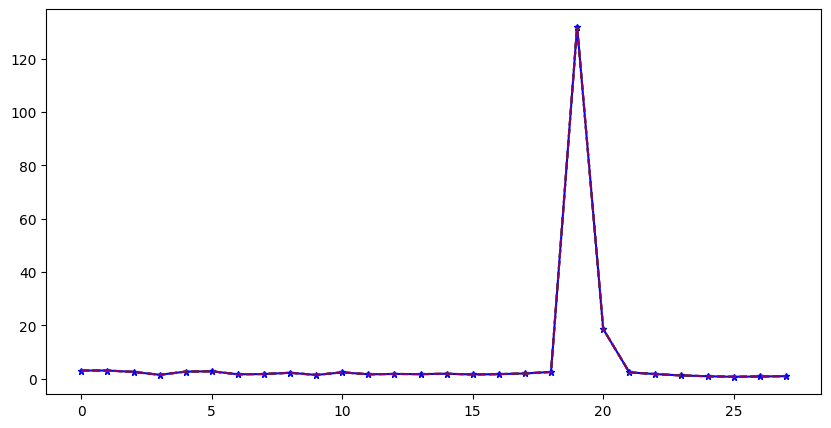

In [13]:
d = 35
Q, R = np.linalg.qr(norm_win_spectra2[d])

t0 = time.time()
for a in range(1000):
    qr_approx2 = np.diag(R @ np.conjugate(R.transpose()))
t1 = time.time()
qr_time = t1 - t0

t0 = time.time()
for a in range(1000):
    qr_approx21 = np.linalg.norm(R, ord=2, axis=1) ** 2
t1 = time.time()
qr_time1 = t1 - t0

t0 = time.time()
for a in range(1000):
    qr_approx22 = np.sum((R * np.conjugate(R)).real, axis=1)
    # qr_approx22 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
t1 = time.time()
qr_time2 = t1 - t0

t0 = time.time()
for a in range(1000):
    qr_approx23 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
t1 = time.time()
qr_time3 = t1 - t0

print("QR time: ", qr_time)
print("QR time1: ", qr_time1)
print("QR time2: ", qr_time2)
print("QR time3: ", qr_time3)

plt.figure(figsize=(10, 5))
# plot with markers and thick lines

plt.plot(qr_approx2, '-*', markersize=5, color="blue", label="QR approximation")
plt.plot(qr_approx21, "--", color="red")
plt.plot(qr_approx22, "--", color="green")
plt.plot(qr_approx23, "--", color="purple")

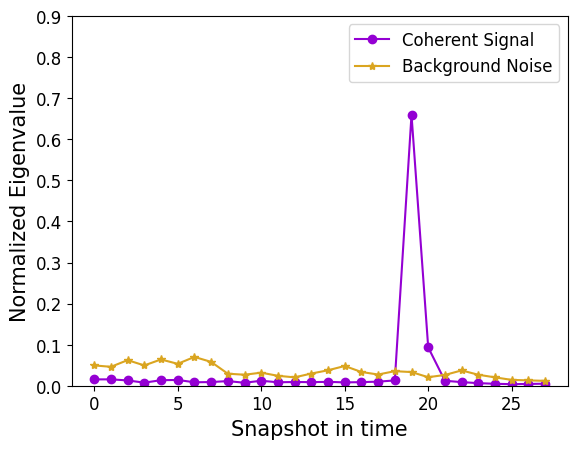

In [14]:
d = 35
Q, R = np.linalg.qr(norm_win_spectra2[d])
qr_signal = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra[d])
qr_noise = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)

plt.plot(qr_signal / np.sum(qr_signal), "-o", color="darkviolet", label="Coherent Signal")
plt.plot(qr_noise / np.sum(qr_noise), "-*", color="goldenrod", label="Background Noise")
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim([0, 0.9])
plt.legend(fontsize=tick_size)


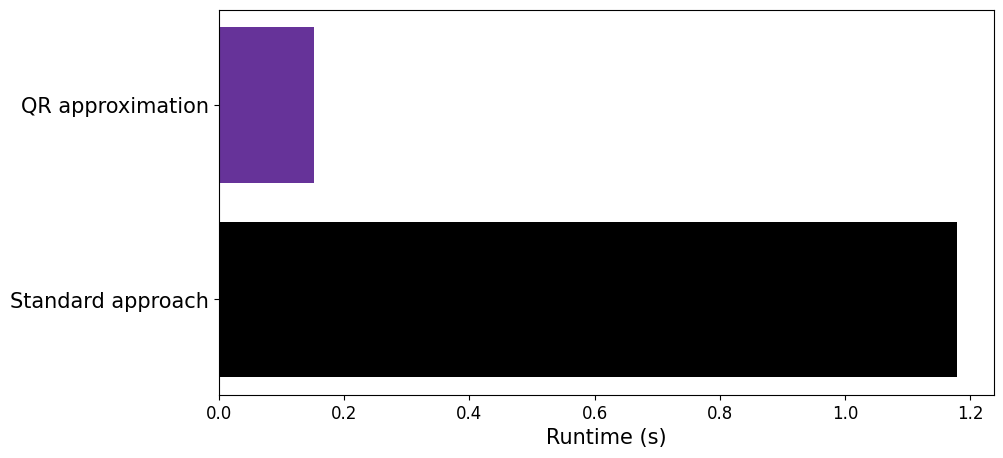

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

# methods = ["Exact", "SVD", "QR approximation"]
methods = ["Standard approach", "QR approximation"]
# methods = [1, 1.2]
times = [svd_time, qr_time]
# times = [eig_time, qr_time]
# bar_labels = ["Exact", "SVD", "QR approximation"]
bar_labels = ["Standard approach", "QR approximation"]
# bar_colors = ['darkviolet', 'goldenrod']
# bar_colors = ['#800000', '#FFD700'] #'#FFA500']
# bar_colors = [colors[3], colors[2], colors[1]]
bar_colors = [colors[3], colors[2]]
# bar_colors = colors[2:4][::-1]

ax.barh(methods, times, label=bar_labels, color=bar_colors, height=0.8)

ax.set_xlabel("Runtime (s)", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=fsize)
# ax.set_title('Runtime')
# ax.legend(fontsize=tick_size)

plt.show()

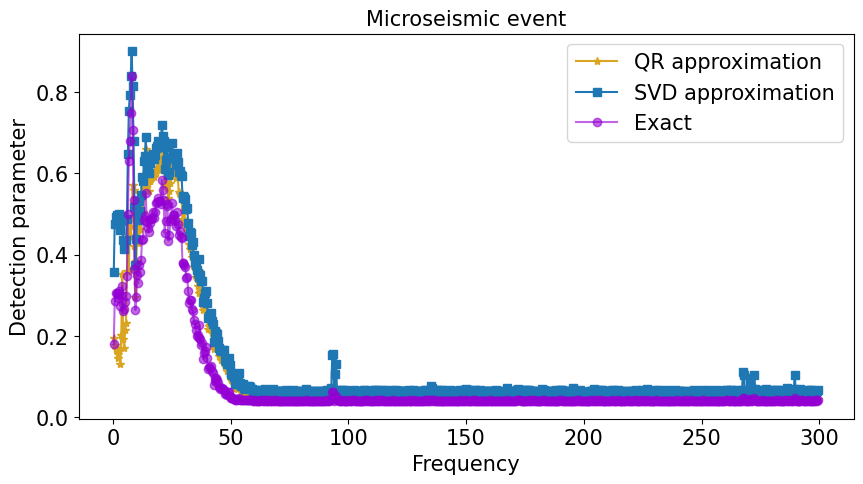

In [16]:
last_freq_index = 750

plt.figure(figsize=(10, 5))

plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_qr2[1:last_freq_index],
    "-*",
    markersize=6,
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_svd2[1:last_freq_index],
    "-s",
    markersize=6,
    label="SVD approximation",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios2[1:last_freq_index],
    "-o",
    markersize=6,
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.title("Microseismic event", fontsize=fsize)
plt.legend(fontsize=fsize)

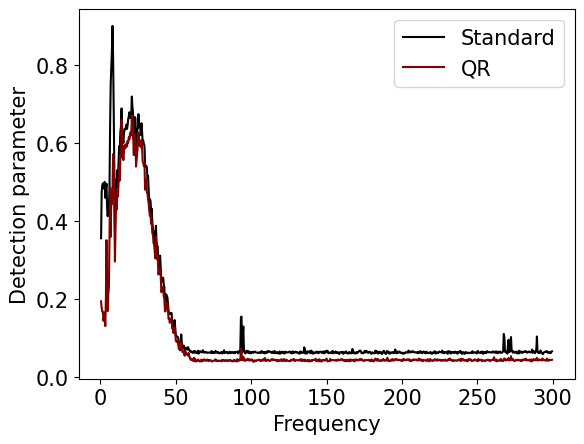

In [17]:
# plt.plot(
#     frequencies[1:last_freq_index],
#     eig_ratios2[1:last_freq_index],
#     color=colors[0],
#     label="Exact",
# )
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_svd2[1:last_freq_index],
    color=colors[3],
    # label="SVD",
    label="Standard",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_qr2[1:last_freq_index],
    # "--",
    color=colors[0],
    label="QR",
)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.title("Microseismic event", fontsize=fsize)
plt.legend(fontsize=fsize)

$$\text{Detection parameter} = \frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

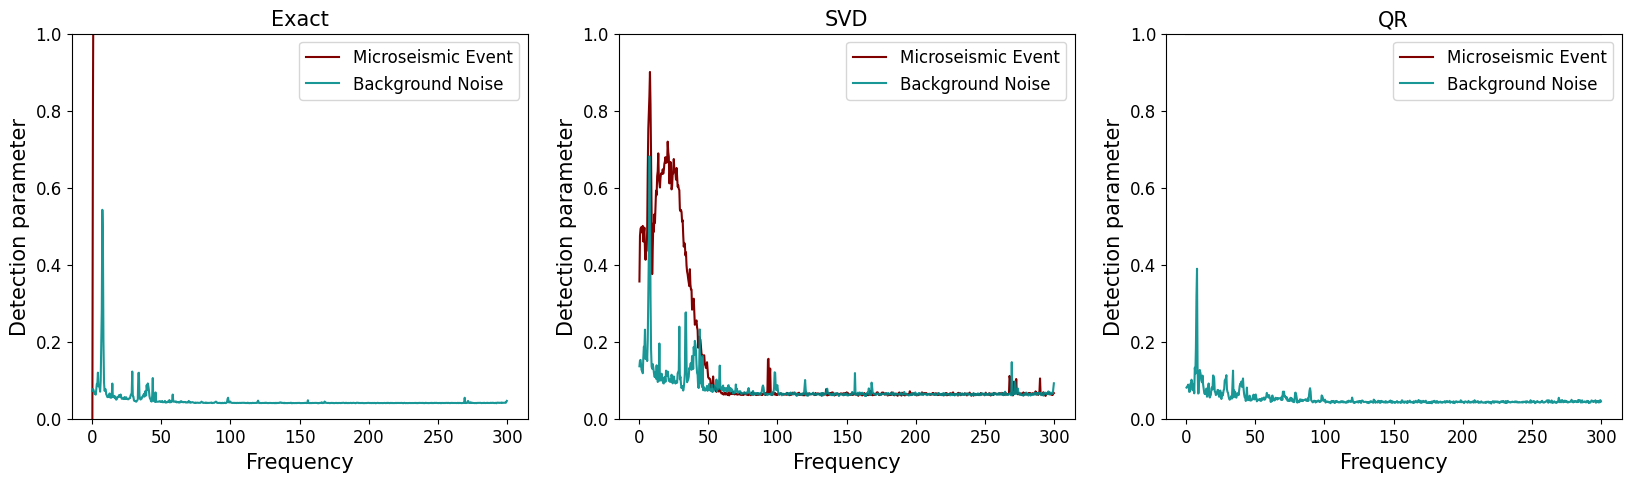

In [ ]:
last_freq_index = 750
tick_size = 12
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios2[1:last_freq_index],
    color=colors[0],
    label="Microseismic Event",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios[1:last_freq_index],
    color=colors[-1],
    alpha=0.9,
    label="Background Noise",
)

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.ylim(0, 1)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("Exact", fontsize=fsize)
plt.legend(fontsize=tick_size)

plt.subplot(1, 3, 2)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_svd2[1:last_freq_index],
    color=colors[0],
    label="Microseismic Event",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_svd[1:last_freq_index],
    color=colors[-1],
    alpha=0.9,
    label="Background Noise",
)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.ylim(0, 1)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("SVD", fontsize=fsize)
plt.legend(fontsize=tick_size)

plt.subplot(1, 3, 3)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_qr2[1:last_freq_index],
    color=colors[0],
    label="Microseismic Event",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_qr[1:last_freq_index],
    color=colors[-1],
    alpha=0.9,
    label="Background Noise",
)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.ylim(0, 1)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("QR", fontsize=fsize)
plt.legend(fontsize=tick_size)

In [ ]:
frequencies

array([0.000e+00, 4.000e-01, 8.000e-01, ..., 4.992e+02, 4.996e+02,
       5.000e+02])

Try with different colors for the event and background noise.

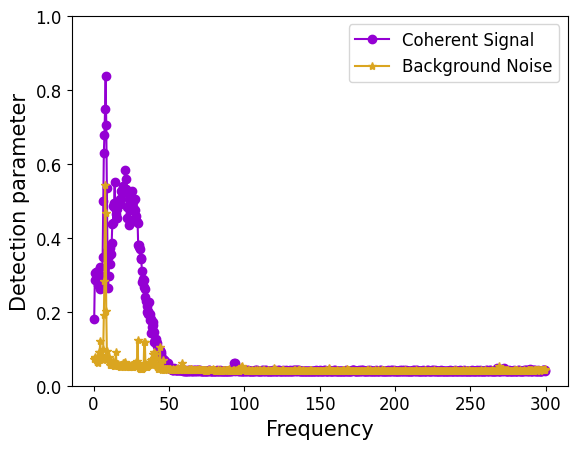

In [112]:
last_freq_index = 750
tick_size = 12
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios2[1:last_freq_index],
    "-o",
    color="darkviolet",
    # alpha=0.5,
    label="Coherent Signal",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios[1:last_freq_index],
    "-*",
    color="goldenrod",
    label="Background Noise",
)
# plt.scatter(
#     frequencies[i],
#     eig_ratios2[i],
#     color="darkviolet",
#     marker='o'
# )
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.ylim(0, 1)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

In [173]:
freq_i = 18
frequencies[freq_i]
# len(frequencies)

7.2

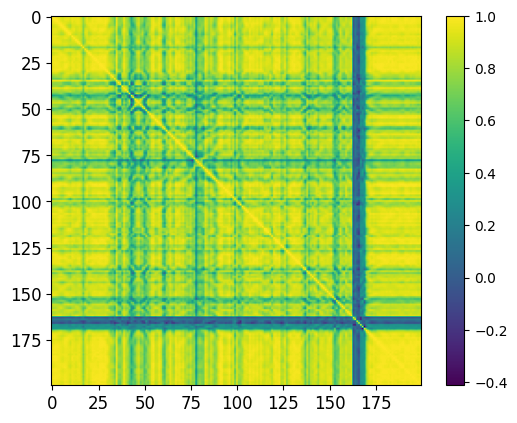

In [174]:
plt.imshow(welch_coherence_mat[freq_i].real, cmap="viridis")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

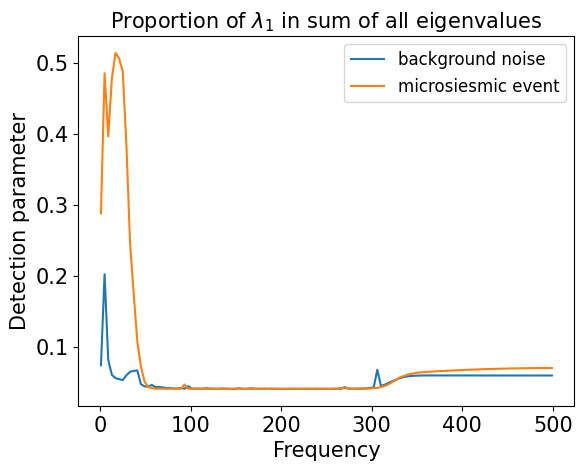

In [175]:
avg_eigs = np.mean(eig_ratios[1:].reshape((125, 10)), axis=1)
avg_eigs2 = np.mean(eig_ratios2[1:].reshape((125, 10)), axis=1)
avg_freq = np.linspace(1, 499, 125)

plt.plot(avg_freq, avg_eigs, label="background noise")
plt.plot(avg_freq, avg_eigs2, label="microsiesmic event")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=tick_size)

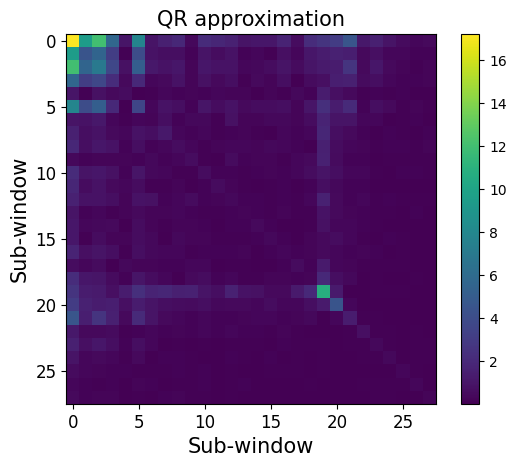

In [176]:
RandA = norm_win_spectra2[freq_i, :, :]
# RandA = norm_win_spectra[freq_i, :, :]
# RandA = norm_win_spectra[freq_i, :, :] ** 2
Q1, R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1 @ R1.T))
plt.ylabel("Sub-window", fontsize=fsize)
plt.xlabel("Sub-window", fontsize=fsize)
plt.title("QR approximation", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,3,3)

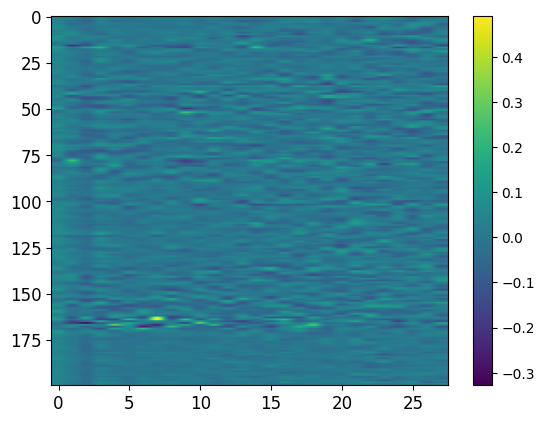

In [177]:
plt.imshow(Q1.imag, aspect="auto")

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

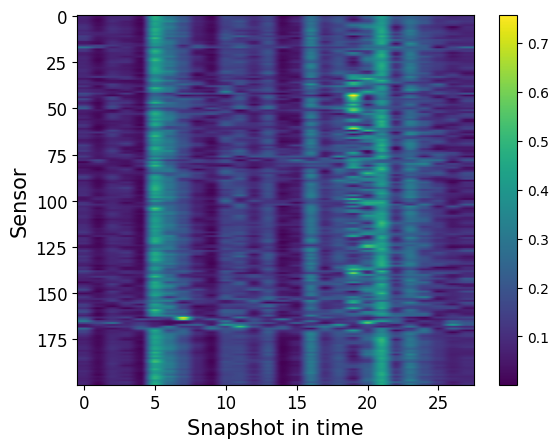

In [178]:
plt.imshow(np.abs(RandA), aspect="auto")
plt.ylabel("Sensor", fontsize=fsize)
# plt.xlabel("Time shot", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
# plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

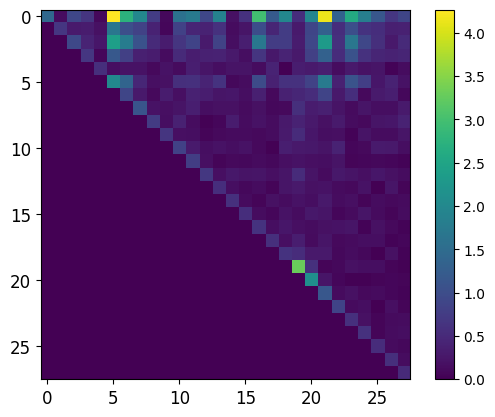

In [179]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
# plt.title('R Matrix', fontsize=15)
# plt.ylabel('Sub-window', fontsize=fsize)
# plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(frequencies)

(0.0, 0.9)

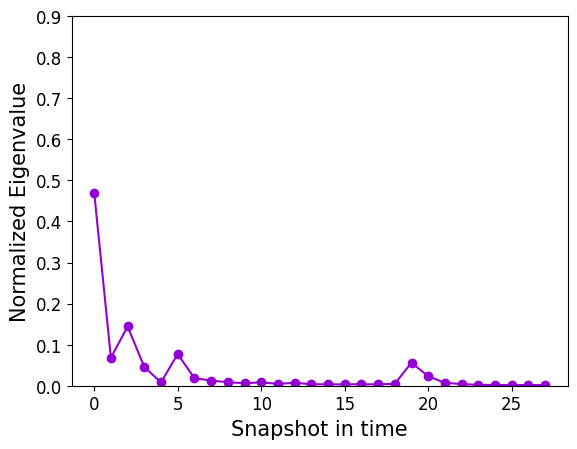

In [180]:
# qr_ = np.diag(np.absolute(R1 @ R1.transpose()))
qr_ = np.diag(R1 @ np.conjugate(R1.transpose()))
plt.plot(qr_ / np.sum(qr_), "-o", color="darkviolet")
# plt.plot(qr / np.sum(qr), "-*", color="goldenrod")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
# plt.ylabel(r"$\frac{d_i}{\sum_{i=1}^{n} d_i}$", fontsize=fsize, rotation="horizontal",
#     labelpad=20,
#     )
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.ylim(0, 0.9)
# plt.title('QR Approximation of Eigenvalues', fontsize=15)
# print(np.max(qr_)/np.sum(np.absolute(qr_)))

In [181]:
eig_ratios_qr2[35]

0.6597995843824092

Text(0.5, 0, '$\\text{Number of time windows in }F(\\omega)$')

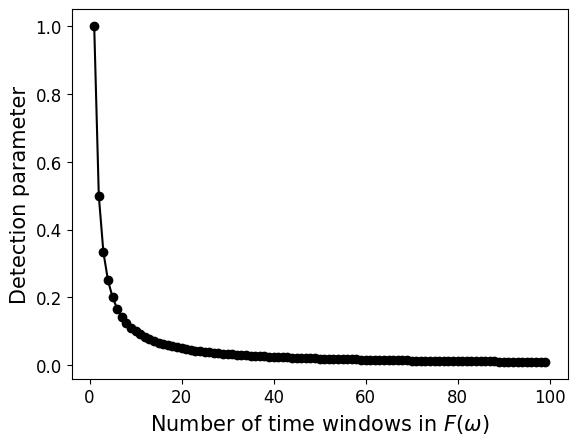

In [182]:
n = np.array(range(1,100))
theta = 1/n

plt.plot(n, theta, 'k-o')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel(r"$\text{Number of time windows in }F(\omega)$", fontsize=fsize)

Use random matrices to show the efficiency of the QR approach in comparison to the exact calculation and the SVD approach. This is the last thing in this notebook because it takes a long time to run.

In [183]:
dim = 2000
dims = [50, 80, 100, 500, 1000, 2000, 3500, 5000, 8000]
qr_times = []
svd_times = []
eig_times = []
rsvd_times = []

for dim in dims:
    approx_rank = int(dim / 2)

    RandA = np.random.randn(dim, int(dim / 2)) + 1j * np.random.randn(dim, int(dim / 2))
    t0 = time.time()
    for a in range(10):
        Q, R = np.linalg.qr(RandA)
        qrr = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    t1 = time.time()
    qr_time = t1 - t0

    # print("QR time: ", qr_time)
    qr_times.append(qr_time)

    t0 = time.time()
    # U, S, Vh = np.linalg.svd(RandA)
    for a in range(10):
        S = np.linalg.svd(RandA, compute_uv=False, hermitian=False)
        SS = np.sort(S)[::-1] ** 2
    t1 = time.time()
    svd_time = t1 - t0

    # print("SVD time: ", svd_time)
    svd_times.append(svd_time)

    # t0 = time.time()
    # eigenvals, _ = np.linalg.eig(RandA @ RandA.transpose())
    # t1 = time.time()
    # eig_time = t1 - t0

    # eig_times.append(eig_time)
    # print("Eigenvalue time: ", svd_time)

    # t0 = time.time()
    # rU, rS, rVh = randomized_svd(RandA, approx_rank)
    # t1 = time.time()
    # rsvd_time = t1 - t0

    # rsvd_times.append(rsvd_time)
    # print("Randomized SVD time: ", rsvd_time)

KeyboardInterrupt: 

In [ ]:
print("QR time: ", qr_times)
print("SVD time: ", svd_times)

QR time:  [0.06403517723083496, 0.002005338668823242, 0.02295660972595215, 1.1473095417022705, 2.8747832775115967, 8.411075830459595, 26.272411823272705, 61.290807247161865, 221.36505770683289]
SVD time:  [0.0009968280792236328, 0.0019974708557128906, 0.01320028305053711, 1.982936143875122, 6.501497268676758, 20.242289781570435, 63.474979639053345, 155.83648443222046, 533.2245442867279]


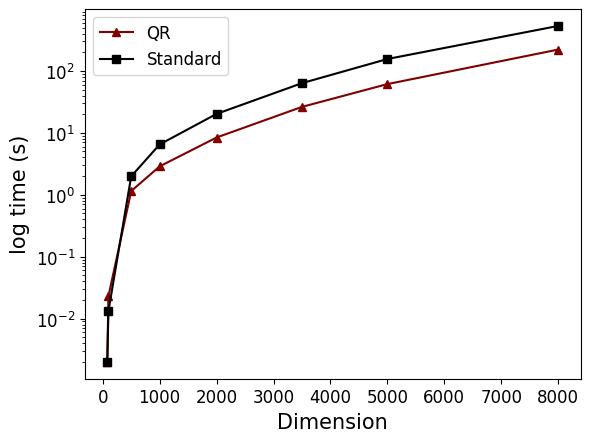

In [ ]:
fsize = 15
ticksize = 12
colors = ["#800000", "#FFD700", "#663399", "#000000", "#008B8B"]

# plt.plot(dims, eig_times, "-o", label="Eigenvalue", color="black")
plt.plot(dims[1:], qr_times[1:], "-^", label="QR", color=colors[0])
plt.plot(dims[1:], svd_times[1:], "-s", label="Standard", color=colors[3])

# plt.plot(dims, rsvd_times, label="Randomized SVD")
plt.xlabel("Dimension", fontsize=fsize)
plt.ylabel("log time (s)", fontsize=fsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
# plt.title("Computation Time vs. Dimension", fontsize=fsize)
plt.legend(fontsize=ticksize)
plt.yscale('log')